<a href="https://colab.research.google.com/github/A-NGJ/AudioExplorers2023/blob/main/AudioExplorers2023_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adjusted last year's model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers.legacy import Adam
from scipy.io import loadmat

import augment
import models

# load train and test data
train_data = loadmat('../data/training.mat')['data']
train_labels = loadmat('../data/training_labels.mat')['data'][0]

In [2]:
# one hot encode labels
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels)

# split data into train, validation, and test sets in ratio 70:15:15
train_data, val_data, train_labels_one_hot, val_labels_one_hot = train_test_split(
    train_data, train_labels_one_hot,
    test_size=0.3, random_state=42
)
val_data, test_data, val_labels_one_hot, test_labels_one_hot = train_test_split(
    val_data, val_labels_one_hot,
    test_size=0.5, random_state=42
)

# augment data
n_samples = train_data.shape[0]

# time shift 25% of training data
train_data_time_shift = np.array([
    augment.time_shift(x, shift_range=0.5)
    for x in train_data[:int(n_samples * 0.25)]])

# time stretch next 25% of training data
train_data_time_stretch = np.array([
    augment.time_stretch(x, rate_range=(0.5, 1.5))
    for x in train_data[int(n_samples * 0.25):int(n_samples * 0.5)]])

# add noise to next 25% of training data
train_data_noise = np.array([
    augment.add_noise(x, noise_factor=0.3)
    for x in train_data[int(n_samples * 0.5):int(n_samples * 0.75)]])

# pitch shift next 25% of training data
train_data_pitch_shift = np.array([
    augment.pitch_shift(x)
    for x in train_data[int(n_samples * 0.75):]])

# combine all augmented data
train_data_augmented = np.concatenate(
    (train_data, train_data_time_shift, train_data_time_stretch, train_data_noise, train_data_pitch_shift)
)

train_labels_one_hot_augmented = np.concatenate(
    (train_labels_one_hot, train_labels_one_hot)
)

assert train_data_augmented.shape[0] == train_labels_one_hot_augmented.shape[0]

In [6]:
# define model parameters
input_shape = (32, 96, 1)
num_classes = 5

# Create EarlyStopping callback on validation loss
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
) 

# hyperparameters
batch_size = 32
epochs = 30
learning_rate = 0.001

model = models.create_cnn_model(input_shape, num_classes)
# compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 96, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 94, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 47, 16)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 47, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 45, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 22, 32)        0         
 2D)                                                           

In [45]:
# train model
history = model.fit(
    train_data,
    train_labels_one_hot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_data, val_labels_one_hot),
    shuffle=True,
)

# evaluate model
test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)

Epoch 1/10
1157/1157 [==============================] - 28s 23ms/step - loss: 1.2892 - accuracy: 0.6040 - val_loss: 0.9812 - val_accuracy: 0.6769
Epoch 2/10
1157/1157 [==============================] - 24s 21ms/step - loss: 0.8724 - accuracy: 0.6888 - val_loss: 0.8207 - val_accuracy: 0.7088
Epoch 3/10
1157/1157 [==============================] - 25s 21ms/step - loss: 0.7766 - accuracy: 0.7145 - val_loss: 0.7016 - val_accuracy: 0.7447
Epoch 4/10
1157/1157 [==============================] - 25s 22ms/step - loss: 0.7178 - accuracy: 0.7364 - val_loss: 0.7041 - val_accuracy: 0.7417
Epoch 5/10
1157/1157 [==============================] - 23s 20ms/step - loss: 0.6655 - accuracy: 0.7580 - val_loss: 0.5923 - val_accuracy: 0.7876
Epoch 6/10
1157/1157 [==============================] - 23s 20ms/step - loss: 0.6294 - accuracy: 0.7728 - val_loss: 0.5992 - val_accuracy: 0.7896
Epoch 7/10
1157/1157 [==============================] - 23s 20ms/step - loss: 0.5929 - accuracy: 0.7870 - val_loss: 0.5840 -

In [46]:
# evaluate model precision and recall
precision = Precision()
precision.update_state(test_labels_one_hot, model.predict(test_data))
precision_result = precision.result().numpy()

recall = Recall()
recall.update_state(test_labels_one_hot, model.predict(test_data))
recall_result = recall.result().numpy()

print('Precision:', precision_result)
print('Recall:', recall_result)

248/248 [==============================] - 1s 3ms/step
Precision: 0.85329473
Recall: 0.74262667


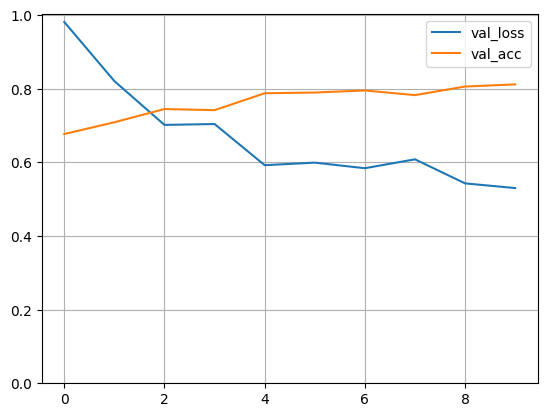

Test loss: 0.5633283257484436
Test accuracy: 0.8013612031936646


In [47]:
# plot loss and accuracy from tensorflow history
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
fig, ax = plt.subplots()
ax.plot(val_loss, label='val_loss')
ax.plot(val_acc, label='val_acc')
# set y axis to start at 0
ax.set_ylim(bottom=0)
ax.legend()
ax.grid()
plt.show()

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

## With augmentation

In [48]:
# create model
model = models.create_cnn_model(input_shape, num_classes)

# compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# train model
history = model.fit(
    train_data_augmented,
    train_labels_one_hot_augmented,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_data, val_labels_one_hot),
    shuffle=True,
    callbacks=[early_stopping],
)

# evaluate model
test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Epoch 1/10
2314/2314 [==============================] - 44s 19ms/step - loss: 0.5773 - accuracy: 0.7923 - val_loss: 0.5341 - val_accuracy: 0.8173
Epoch 2/10
2314/2314 [==============================] - 40s 17ms/step - loss: 0.5447 - accuracy: 0.8047 - val_loss: 0.5725 - val_accuracy: 0.7942
Epoch 3/10
2314/2314 [==============================] - 40s 17ms/step - loss: 0.5252 - accuracy: 0.8101 - val_loss: 0.4887 - val_accuracy: 0.8302
Epoch 4/10
2314/2314 [==============================] - 40s 17ms/step - loss: 0.5144 - accuracy: 0.8144 - val_loss: 0.4895 - val_accuracy: 0.8320
Epoch 5/10
2314/2314 [==============================] - 40s 17ms/step - loss: 0.4994 - accuracy: 0.8189 - val_loss: 0.4805 - val_accuracy: 0.8365
Epoch 6/10
2314/2314 [==============================] - 40s 17ms/step - loss: 0.4938 - accuracy: 0.8218 - val_loss: 0.5044 - val_accuracy: 0.8244
Epoch 7/10
2314/2314 [==============================] - 40s 17ms/step - loss: 0.4817 - accuracy: 0.8253 - val_loss: 0.5164 -

# Minimal ResNet

In [49]:
# create resnet model
resnet = models.create_resnet(input_shape, num_classes)
resnet.summary()

epochs = 20

# compile resnet
resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 96, 1)]  0           []                               
                                                                                                  
 conv2d_61 (Conv2D)             (None, 16, 48, 16)   160         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_53 (BatchN  (None, 16, 48, 16)  64          ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_43 (Activation)     (None, 16, 48, 16)   0           ['batch_normalization_53[0]

In [50]:
# train model
history = resnet.fit(
    train_data,
    train_labels_one_hot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_data, val_labels_one_hot),
    shuffle=True,
)

# evaluate model
test_loss, test_acc = resnet.evaluate(test_data, test_labels_one_hot)

Epoch 1/20
1157/1157 [==============================] - 53s 43ms/step - loss: 0.7084 - accuracy: 0.7407 - val_loss: 0.6876 - val_accuracy: 0.7520
Epoch 2/20
1157/1157 [==============================] - 48s 41ms/step - loss: 0.5632 - accuracy: 0.7983 - val_loss: 0.6683 - val_accuracy: 0.7563
Epoch 3/20
1157/1157 [==============================] - 48s 41ms/step - loss: 0.5099 - accuracy: 0.8172 - val_loss: 0.4938 - val_accuracy: 0.8202
Epoch 4/20
1157/1157 [==============================] - 48s 41ms/step - loss: 0.4735 - accuracy: 0.8323 - val_loss: 0.4716 - val_accuracy: 0.8390
Epoch 5/20
1157/1157 [==============================] - 967s 837ms/step - loss: 0.4393 - accuracy: 0.8440 - val_loss: 0.5674 - val_accuracy: 0.7939
Epoch 6/20
1157/1157 [==============================] - 1250s 1s/step - loss: 0.4121 - accuracy: 0.8527 - val_loss: 0.5951 - val_accuracy: 0.7949
Epoch 7/20
1157/1157 [==============================] - 48s 41ms/step - loss: 0.3886 - accuracy: 0.8597 - val_loss: 0.5173

248/248 [==============================] - 1s 3ms/step
Precision: 0.86161697
Recall: 0.78711873


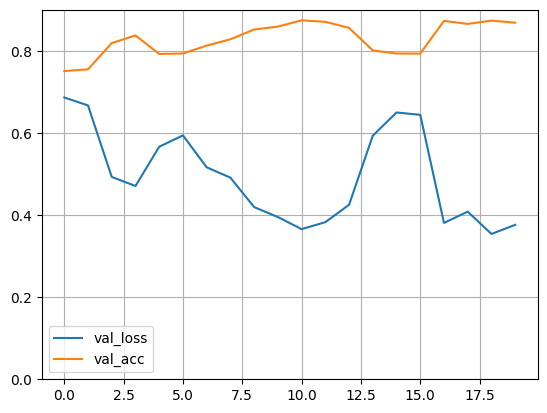

Test loss: 0.41257476806640625
Test accuracy: 0.8619863986968994


In [51]:
# evaluate model precision and recall
precision = Precision()
precision.update_state(test_labels_one_hot, model.predict(test_data))
precision_result = precision.result().numpy()

recall = Recall()
recall.update_state(test_labels_one_hot, model.predict(test_data))
recall_result = recall.result().numpy()

print('Precision:', precision_result)
print('Recall:', recall_result)

# plot loss and accuracy from tensorflow history
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
fig, ax = plt.subplots()
ax.plot(val_loss, label='val_loss')
ax.plot(val_acc, label='val_acc')
# set y axis to start at 0
ax.set_ylim(bottom=0)
ax.legend()
ax.grid()
plt.show()

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

## With augmentation

In [7]:
resnet = models.create_resnet(input_shape, num_classes)
resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# train model
history = resnet.fit(
    train_data_augmented,
    train_labels_one_hot_augmented,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_data, val_labels_one_hot),
    shuffle=True,
    callbacks=[early_stopping],
)

# evaluate model
test_loss, test_acc = resnet.evaluate(test_data, test_labels_one_hot)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Epoch 1/30


2023-04-13 16:18:06.360089: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2314/2314 [==============================] - 93s 39ms/step - loss: 0.6575 - accuracy: 0.7611 - val_loss: 0.6383 - val_accuracy: 0.7611
Epoch 2/30
2314/2314 [==============================] - 92s 40ms/step - loss: 0.5222 - accuracy: 0.8128 - val_loss: 0.7803 - val_accuracy: 0.7082
Epoch 3/30
2314/2314 [==============================] - 91s 39ms/step - loss: 0.4588 - accuracy: 0.8343 - val_loss: 0.5064 - val_accuracy: 0.8243
Epoch 4/30
2314/2314 [==============================] - 91s 39ms/step - loss: 0.4071 - accuracy: 0.8538 - val_loss: 0.5488 - val_accuracy: 0.8129
Epoch 5/30
2314/2314 [==============================] - 92s 40ms/step - loss: 0.3669 - accuracy: 0.8682 - val_loss: 0.4530 - val_accuracy: 0.8389
Epoch 6/30
2314/2314 [==============================] - 91s 39ms/step - loss: 0.3339 - accuracy: 0.8790 - val_loss: 0.5358 - val_accuracy: 0.8248
Epoch 7/30
2314/2314 [==============================] - 92s 40ms/step - loss: 0.3051 - accuracy: 0.8879 - val_loss: 0.3614 - val_accura

KeyboardInterrupt: 